# Pré-Processamento

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

Dataset: https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset?resource=download

In [ ]:
data = pd.read_csv('synthetic_coffee_health_10000.csv', sep = ',')

In [ ]:
# plotar heatmap de valores nulos
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull().T, cbar=False, cmap='viridis')
plt.title('Heatmap de Valores Nulos')
plt.show()

In [ ]:
dataWithoutHealthIssues = data.drop(columns=['Health_Issues'])
dataDroppedNA = data.dropna()
dataWithoutHealthIssues.shape, dataDroppedNA.shape

Se removermos a feature "Health_Issues", a qual é a única que possui valores nulo, teríamos 10000 ocorrências para tentar prever a "Sleep_Quality".

Se mantivermos a feature "Health_Issues", e jogar fora todas as ocorrências em que ela é nula, ainda teremos 4059 ocorrências para prever "Sleep_Quality". O que não me parece ruim.

In [ ]:
dataWithoutHealthIssues["Sleep_Quality"].value_counts().sort_index().plot(kind='bar')

In [ ]:
dataDroppedNA["Sleep_Quality"].value_counts().sort_index().plot(kind='bar')

Em ambos os casos, as classes continuam bem desbalanceadas, então não faz muita diferença qual corte escolher. Vamos trabalhar com o dataset com 10000 pra ficar redondo.

## Plot de cada coluna

In [ ]:
dataWithoutHealthIssues["Age"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Gender"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Country"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Coffee_Intake"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Caffeine_mg"].value_counts().sort_index().plot(kind='line', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Sleep_Hours"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))


In [ ]:
dataWithoutHealthIssues["Sleep_Quality"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["BMI"].value_counts().sort_index().plot(kind='line', figsize=(12, 3))


In [ ]:
dataWithoutHealthIssues["Heart_Rate"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Stress_Level"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Physical_Activity_Hours"].value_counts().sort_index().plot(kind='line', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Occupation"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Smoking"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Alcohol_Consumption"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues.head()

## Processamento para o KNN

- Age: numérica contínua. Normalizar.
- Gender: categórica nominal com 3 valores únicos. Aplicar OneHot. 
- Country: categórica nominal com 20 valores únicos. Aplicar OneHot. (Considerar agrupar por continentes, perguntar ao professor).
- Coffee_Intake: numérica contínua. Normalizar. (Conversar com o professor se "cortar" os extremos pode ser bom para o treinamento).
- Caffeine_mg: numérica contínua. Normalizar.
- Sleep_Hours: numérica contínua. Normalizar.
- Sleep_Quality: categórica ordinal e target dos modelos. Só converter para numérica manualmente.
- BMI: numérica contínua. Normalizar.
- Heart_Rate: numérica contínua. Normalizar.
- Stress_Level: categórica ordinal com 3 valores únicos. Converter para numérica manualmente.
- Physical_Activity_Hours: numérica contínua. Normalizar.
- Occupation: categórica nominal com 5 valores únicos: Aplicar OneHot.
- Smoking: binária numérica. Fazer nada.
- Alcohol_Consumption: binária numérica. Fazer nada.

OBS: vou remover a coluna de país para verificar se melhora as métricas do KNN

In [ ]:
dataKNN = dataWithoutHealthIssues.copy()

# Normalização das variáveis numéricas
scaler = MinMaxScaler()
columnsToNormalize = ['Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours']
dataKNN[columnsToNormalize] = scaler.fit_transform(dataKNN[columnsToNormalize])

# OneHot para variáveis categóricas nominais
# dataKNN.drop(columns=['Country'], inplace=True) # experimento
# dataKNN = pd.get_dummies(dataKNN, columns=['Gender', 'Occupation'], drop_first=False, dtype=int) # experimento
dataKNN = pd.get_dummies(dataKNN, columns=['Gender', 'Country', 'Occupation'], drop_first=False, dtype=int)

# Conversão manual das colunas categoricas ordinais
sleepQualityMap = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Excellent': 3
}

stressLevelMap = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

dataKNN['Sleep_Quality'] = dataKNN['Sleep_Quality'].map(sleepQualityMap)
dataKNN['Stress_Level'] = dataKNN['Stress_Level'].map(stressLevelMap)

dataKNN.drop(columns=['ID'], inplace=True)

In [ ]:
dataWithoutHealthIssues.head()

In [ ]:
dataKNN.head()

In [ ]:
# divide o dataset em treino, validacao e teste
train, test = train_test_split(dataKNN, test_size=0.2, stratify=dataKNN["Sleep_Quality"])
train, validation = train_test_split(train, test_size=0.2, stratify=train["Sleep_Quality"])
train.shape, validation.shape, test.shape

In [ ]:
train.to_csv("trainKNN.csv", index=False)
validation.to_csv("validationKNN.csv", index=False)
test.to_csv("testKNN.csv", index=False)

## Processamento para Naive Bayes

Aqui optamos por converter valores numéricos para intervalar, através de discretizações. 

- Age: numérica contínua. Discretizar.
- Gender: categórica nominal com 3 valores únicos. Converter para numérica.
- Country: categórica nominal com 20 valores únicos. Converter para numérica.
- Coffee_Intake: numérica contínua. Discretizar.
- Caffeine_mg: numérica contínua. Discretizar.
- Sleep_Hours: numérica contínua. Discretizar.
- Sleep_Quality: categórica ordinal e target dos modelos. Converter para numérica.
- BMI: numérica contínua. Discretizar.
- Heart_Rate: numérica contínua. Discretizar.
- Stress_Level: categórica ordinal com 3 valores únicos. Converter para numérica.
- Physical_Activity_Hours: numérica contínua. Discretizar.
- Occupation: categórica nominal com 5 valores únicos. Converter para numérica.
- Smoking: binária numérica. Fazer nada.
- Alcohol_Consumption: binária numérica. Fazer nada.

In [ ]:
dataNB = dataWithoutHealthIssues.copy()

# Colunas numéricas a serem discretizadas
columns_to_discretize = [
    'Age',
    'Coffee_Intake',
    'Caffeine_mg',
    'Sleep_Hours',
    'BMI',
    'Heart_Rate',
    'Physical_Activity_Hours'
]

# Discretização usando qcut (quantis) para criar 4 bins para cada coluna
for col in columns_to_discretize:
    dataNB[col] = pd.qcut(dataNB[col], q=4, labels=False, duplicates='drop')

# Conversão manual das colunas categoricas ordinais e nominais
genderMap = {
    'Male': 0,
    'Female': 1,
    'Other': 2
}

countryMap = {
    "Canada": 0,
    "India": 1,
    "Norway": 2,
    "China": 3,
    "UK": 4,
    "Sweden": 5,
    "South Korea": 6,
    "Finland": 7,
    "Italy": 8,
    "Switzerland": 9,
    "France": 10,
    "Germany": 11,
    "Australia": 12,
    "Belgium": 13,
    "Netherlands": 14,
    "Spain": 15,
    "Mexico": 16,
    "Japan": 17,
    "Brazil": 18,
    "USA": 19
}

sleepQualityMap = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Excellent': 3
}

stressLevelMap = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

ocupationMap = {
    "Office" : 1,
    "Other" : 2,
    "Student" : 3,
    "Healthcare" : 4,
    "Service" : 5,
}

dataNB['Gender'] = dataNB['Gender'].map(genderMap)
dataNB['Country'] = dataNB['Country'].map(countryMap)
dataNB['Sleep_Quality'] = dataNB['Sleep_Quality'].map(sleepQualityMap)
dataNB['Stress_Level'] = dataNB['Stress_Level'].map(stressLevelMap)
dataNB['Occupation'] = dataNB['Occupation'].map(ocupationMap)

dataNB.drop(columns=['ID'], inplace=True)

In [ ]:
dataWithoutHealthIssues.head()

In [ ]:
dataNB.head()

In [ ]:
train, test = train_test_split(dataNB, test_size=0.2, stratify=dataNB["Sleep_Quality"])
train, validation = train_test_split(train, test_size=0.2, stratify=train["Sleep_Quality"])
train.shape, validation.shape, test.shape

In [ ]:
train.to_csv("trainNB.csv", index=False)
validation.to_csv("validationNB.csv", index=False)
test.to_csv("testNB.csv", index=False)

## Processamento para Árvore de Decisão

- Age: numérica contínua. Fazer nada.
- Gender: categórica nominal com 3 valores únicos. Converter para numérica.
- Country: categórica nominal com 20 valores únicos. Converter para numérica.
- Coffee_Intake: numérica contínua. Fazer nada.
- Caffeine_mg: numérica contínua. Fazer nada.
- Sleep_Hours: numérica contínua. Fazer nada.
- Sleep_Quality: categórica ordinal e target dos modelos. Converter para numérica.
- BMI: numérica contínua. Fazer nada.
- Heart_Rate: numérica contínua. Fazer nada.
- Stress_Level: categórica ordinal com 3 valores únicos. Converter para numérica.
- Physical_Activity_Hours: numérica contínua. Fazer nada.
- Occupation: categórica nominal com 5 valores únicos. Converter para numérica.
- Smoking: binária numérica. Fazer nada.
- Alcohol_Consumption: binária numérica. Fazer nada.

In [ ]:
dataAD = dataWithoutHealthIssues.copy()

# Conversão manual das colunas categoricas ordinais e nominais
genderMap = {
    'Male': 0,
    'Female': 1,
    'Other': 2
}

countryMap = {
    "Canada": 0,
    "India": 1,
    "Norway": 2,
    "China": 3,
    "UK": 4,
    "Sweden": 5,
    "South Korea": 6,
    "Finland": 7,
    "Italy": 8,
    "Switzerland": 9,
    "France": 10,
    "Germany": 11,
    "Australia": 12,
    "Belgium": 13,
    "Netherlands": 14,
    "Spain": 15,
    "Mexico": 16,
    "Japan": 17,
    "Brazil": 18,
    "USA": 19
}

sleepQualityMap = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Excellent': 3
}

stressLevelMap = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

ocupationMap = {
    "Office" : 1,
    "Other" : 2,
    "Student" : 3,
    "Healthcare" : 4,
    "Service" : 5,
}

dataAD['Gender'] = dataAD['Gender'].map(genderMap)
dataAD['Country'] = dataAD['Country'].map(countryMap)
dataAD['Sleep_Quality'] = dataAD['Sleep_Quality'].map(sleepQualityMap)
dataAD['Stress_Level'] = dataAD['Stress_Level'].map(stressLevelMap)
dataAD['Occupation'] = dataAD['Occupation'].map(ocupationMap)

dataAD.drop(columns=['ID'], inplace=True)

In [ ]:
dataWithoutHealthIssues.head()

In [ ]:
dataAD.head()

In [ ]:
train, test = train_test_split(dataAD, test_size=0.2, stratify=dataAD["Sleep_Quality"])
train, validation = train_test_split(train, test_size=0.2, stratify=train["Sleep_Quality"])
train.shape, validation.shape, test.shape

In [ ]:
train.to_csv("trainAD.csv", index=False)
validation.to_csv("validationAD.csv", index=False)
test.to_csv("testAD.csv", index=False)

# KNN

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import plotly.graph_objects as go
import shap
import numpy as np

## Treinamento

In [73]:
train = pd.read_csv("trainKNN.csv")
validation = pd.read_csv("validationKNN.csv")
test = pd.read_csv("testKNN.csv")

In [74]:
# Separa features e target
X_train = train.drop(columns=['Sleep_Quality'])
y_train = train['Sleep_Quality']

X_val = validation.drop(columns=['Sleep_Quality'])
y_val = validation['Sleep_Quality']

X_test = test.drop(columns=['Sleep_Quality'])
y_test = test['Sleep_Quality']

In [75]:
# Teste do cotovelo: varie o número de vizinhos e avalia tanto na validação quanto no teste
k_range = range(1, 50)
scores_val = []
f1s_val = []
scores_test = []
f1s_test = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Avaliação na validação
    y_pred_val = knn.predict(X_val)
    scores_val.append(accuracy_score(y_val, y_pred_val))
    f1s_val.append(f1_score(y_val, y_pred_val, average='weighted'))

    # Avaliação no teste
    y_pred_test = knn.predict(X_test)
    scores_test.append(accuracy_score(y_test, y_pred_test))
    f1s_test.append(f1_score(y_test, y_pred_test, average='weighted'))

# Gráfico interativo do teste do cotovelo para Validação vs Teste
fig = go.Figure()

# Métricas de Validação
fig.add_trace(go.Scatter(x=list(k_range), y=f1s_val, mode='lines', name='F1-score (Validação)', line=dict(dash='dash', color='blue')))
fig.add_trace(go.Scatter(x=list(k_range), y=scores_val, mode='lines', name='Acurácia (Validação)', line=dict(dash='dash', color='red')))

# Métricas de Teste
fig.add_trace(go.Scatter(x=list(k_range), y=f1s_test, mode='lines', name='F1-score (Teste)', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=list(k_range), y=scores_test, mode='lines', name='Acurácia (Teste)', line=dict(color='red')))

fig.update_layout(
    title='Teste do Cotovelo (Validação vs. Teste) para KNN',
    xaxis_title='Número de Vizinhos (k)',
    yaxis_title='Métrica',
    legend_title='Métrica',
    template='plotly_white'
)
fig.show()

In [76]:
# Teste do cotovelo: varie o número de vizinhos e avalia tanto na validação quanto no teste
k_range = range(1, 50)
scores_val = []
f1s_val = []
scores_test = []
f1s_test = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)

    # Avaliação na validação
    y_pred_val = knn.predict(X_val)
    scores_val.append(accuracy_score(y_val, y_pred_val))
    f1s_val.append(f1_score(y_val, y_pred_val, average='weighted'))

    # Avaliação no teste
    y_pred_test = knn.predict(X_test)
    scores_test.append(accuracy_score(y_test, y_pred_test))
    f1s_test.append(f1_score(y_test, y_pred_test, average='weighted'))

# Gráfico interativo do teste do cotovelo para Validação vs Teste
fig = go.Figure()

# Métricas de Validação
fig.add_trace(go.Scatter(x=list(k_range), y=f1s_val, mode='lines', name='F1-score (Validação)', line=dict(dash='dash', color='blue')))
fig.add_trace(go.Scatter(x=list(k_range), y=scores_val, mode='lines', name='Acurácia (Validação)', line=dict(dash='dash', color='red')))

# Métricas de Teste
fig.add_trace(go.Scatter(x=list(k_range), y=f1s_test, mode='lines', name='F1-score (Teste)', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=list(k_range), y=scores_test, mode='lines', name='Acurácia (Teste)', line=dict(color='red')))

fig.update_layout(
    title='Teste do Cotovelo (Validação vs. Teste) para KNN',
    xaxis_title='Número de Vizinhos (k)',
    yaxis_title='Métrica',
    legend_title='Métrica',
    template='plotly_white'
)
fig.show()

In [77]:
# Printa as métricas de avaliação de um determinado k
k = 4
print("- F1-score de validação: ", f1s_val[k-1])
print("- F1-score de teste: ", f1s_test[k-1])
print("- Acurácia de validação: ", scores_val[k-1])
print("- Acurácia de teste: ", scores_test[k-1])

- F1-score de validação:  0.7412034916580634
- F1-score de teste:  0.7400741881301085
- Acurácia de validação:  0.759375
- Acurácia de teste:  0.7635


- Como as classes são desbalanceadas, estarei olhando para o f1-score como métrica ideal. 
    - Usando o algoritmo sem a aplicação de pesos e um K = 4.
        - F1-score de validação:  0.757105380881465
        - F1-score de teste:  0.7629421968792068
        - Acurácia de validação:  0.7975
        - Acurácia de teste:  0.805

    - Usando o algoritmo com a aplicação de pesos e um K = 4.
        - F1-score de validação:  0.7412034916580634
        - F1-score de teste:  0.7400741881301085
        - Acurácia de validação:  0.759375
        - Acurácia de teste:  0.7635
        
- O uso de pesos não mostrou diferença significativa.

- Em todos os casos as métricas da validação e teste estavam muito similares. Logo ele não parece ter overfitado. Como as métricas não sairam muito boas nesses casos, seria bom explorar um kfold, ou leave one out, já que o dataset é pequeno.

In [78]:
knn_final = KNeighborsClassifier(n_neighbors=k)
knn_final.fit(X_train, y_train)

,n_neighbors,4
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## Interpretação

c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



Calculando valores SHAP... (isso pode demorar alguns minutos)


  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

  2%|▏         | 1/50 [00:01<00:55,  1.14s/it]c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

  4%|▍         | 2/50 [00:02<00:51,  1.07s/it]c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWar

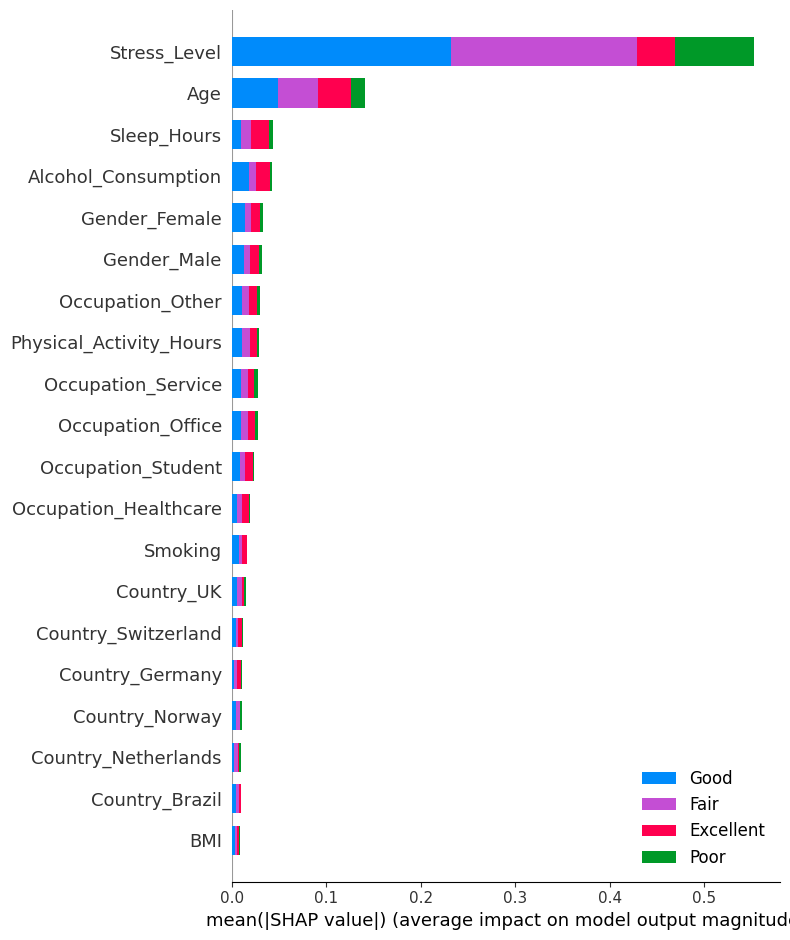

In [79]:
# Função wrapper para retornar probabilidades
def predict_proba_wrapper(X):
    return knn_final.predict_proba(X)

# Cria uma amostra menor para o background (baseline)
background_sample = X_train.sample(n=100, random_state=42)
test_sample = X_test.sample(n=50, random_state=42)

# Inicializa o KernelExplainer
explainer = shap.KernelExplainer(predict_proba_wrapper, background_sample)

# Calcula valores SHAP (pode demorar um pouco)
print("Calculando valores SHAP... (isso pode demorar alguns minutos)")
shap_values = explainer.shap_values(test_sample)

# 2. Feature importance plot - importância geral das features
shap.summary_plot(shap_values, test_sample, plot_type="bar", class_names=['Poor', 'Fair', 'Good', 'Excellent'])

# Naive Bayes

In [80]:
import pandas as pd
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
import numpy as np

## Treinamento

In [81]:
train = pd.read_csv("trainNB.csv")
validation = pd.read_csv("validationNB.csv")
test = pd.read_csv("testNB.csv")

In [82]:
# Separa features e target
X_train = train.drop(columns=['Sleep_Quality'])
y_train = train['Sleep_Quality']

X_val = validation.drop(columns=['Sleep_Quality'])
y_val = validation['Sleep_Quality']

X_test = test.drop(columns=['Sleep_Quality'])
y_test = test['Sleep_Quality']

In [83]:
# Treina o modelo Naive Bayes
nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None
,min_categories,None


In [84]:
# Faz predições no conjunto de validação
y_val_pred = nb_model.predict(X_val)

# Faz predições no conjunto de teste
y_test_pred = nb_model.predict(X_test)

# Avalia o modelo na validação
print('- F1-score de Validação:', f1_score(y_val, y_val_pred, average='weighted'))
print('- F1-score de Teste:', f1_score(y_test, y_test_pred, average='weighted'))
print('- Acurácia de Validação:', accuracy_score(y_val, y_val_pred))
print('- Acurácia de Teste:', accuracy_score(y_test, y_test_pred))

- F1-score de Validação: 0.9037764270613107
- F1-score de Teste: 0.9017684134850293
- Acurácia de Validação: 0.900625
- Acurácia de Teste: 0.9005


- Novamente, como temos classes desbalanceadas, estaremos olhando para o f1. Usando o modelo padrão, sem atribuir valores especificos aos hiperparametros, obtivemos:
    - F1-score de Validação: 0.9037764270613107
    - F1-score de Teste: 0.9017684134850293
    - Acurácia de Validação: 0.900625
    - Acurácia de Teste: 0.9005
        
- Resultados excelentes. Como não há diferenças entre validação e teste, ele generalizou bem aparentemente. Está bom demais para ser verdade, no entanto não há muitos hiperparâmetros para mexer no Naive Bayes.

OBS: segundo a documentação, o role de Laplace para remover probabilidades 0 é aplicado por padrão. Nos hiperparâmetros ele é o alpha, que igual a 1 ativa o Laplace.

## Interpretação

c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but CategoricalNB was fitted with feature names

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but CategoricalNB was fitted with feature names

c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but CategoricalNB was fitted with feature names

  2%|▏         | 1/50 [00:00<00:06,  7.57it/s]c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but CategoricalNB was fitted with feature names

c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but CategoricalNB was fitted w

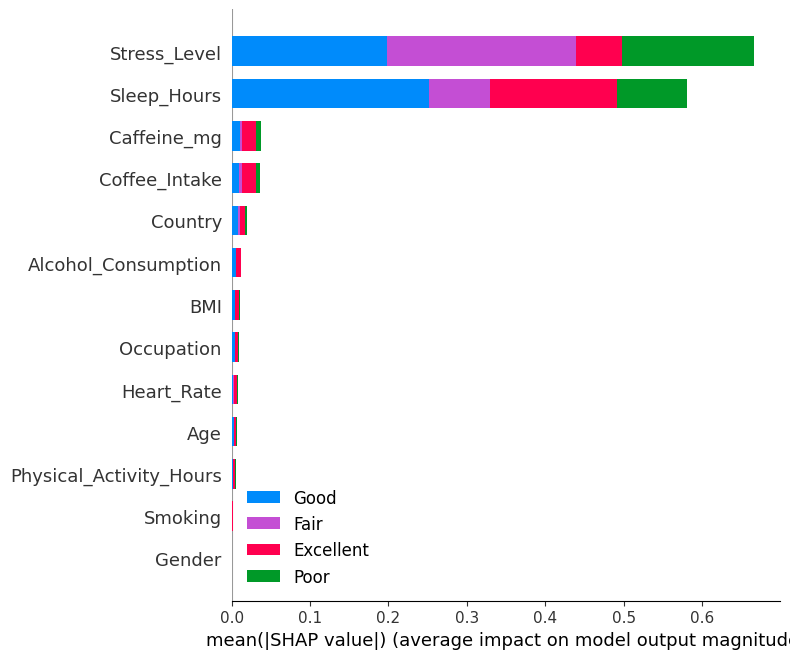

In [85]:
# Método alternativo usando KernelExplainer (mais lento mas mais estável)
def predict_proba_wrapper(X):
    return nb_model.predict_proba(X)

# Cria uma amostra ainda menor para o background
background_sample = X_train.sample(n=100, random_state=42)
test_sample = X_test.sample(n=50, random_state=42)

# Inicializa o KernelExplainer
explainer = shap.KernelExplainer(predict_proba_wrapper, background_sample)

# Calcula valores SHAP
shap_values = explainer.shap_values(test_sample)

# Visualizações
shap.summary_plot(shap_values, test_sample, plot_type="bar", class_names=['Poor', 'Fair', 'Good', 'Excellent'])

# Árvore de Decisão

In [97]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import shap
import numpy as np

## Treinamento

In [98]:
train = pd.read_csv("trainAD.csv")
validation = pd.read_csv("validationAD.csv")
test = pd.read_csv("testAD.csv")

In [99]:
# Separa features e target
X_train = train.drop(columns=['Sleep_Quality'])
y_train = train['Sleep_Quality']

X_val = validation.drop(columns=['Sleep_Quality'])
y_val = validation['Sleep_Quality']

X_test = test.drop(columns=['Sleep_Quality'])
y_test = test['Sleep_Quality']

In [100]:
# Teste do cotovelo para a profundidade da árvore
depth_range = range(1, 21) # Testar profundidades de 1 a 20
scores_val = []
precisions_val = []
recalls_val = []
f1s_val = []

scores_test = []
precisions_test = []
recalls_test = []
f1s_test = []

for depth in depth_range:
    ad_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    ad_model.fit(X_train, y_train)

    # Avaliação na validação
    y_pred_val = ad_model.predict(X_val)
    scores_val.append(accuracy_score(y_val, y_pred_val))
    precisions_val.append(precision_score(y_val, y_pred_val, average='weighted'))
    recalls_val.append(recall_score(y_val, y_pred_val, average='weighted'))
    f1s_val.append(f1_score(y_val, y_pred_val, average='weighted'))

    # Avaliação no teste
    y_pred_test = ad_model.predict(X_test)
    scores_test.append(accuracy_score(y_test, y_pred_test))
    precisions_test.append(precision_score(y_test, y_pred_test, average='weighted'))
    recalls_test.append(recall_score(y_test, y_pred_test, average='weighted'))
    f1s_test.append(f1_score(y_test, y_pred_test, average='weighted'))

# Gráfico interativo do teste do cotovelo para Validação vs Teste
fig = go.Figure()

# Métricas de Validação
fig.add_trace(go.Scatter(x=list(depth_range), y=f1s_val, mode='lines', name='F1-score (Validação)', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=list(depth_range), y=scores_val, mode='lines', name='Acurácia (Validação)', line=dict(dash='dash')))

# Métricas de Teste
fig.add_trace(go.Scatter(x=list(depth_range), y=f1s_test, mode='lines', name='F1-score (Teste)'))
fig.add_trace(go.Scatter(x=list(depth_range), y=scores_test, mode='lines', name='Acurácia (Teste)'))


fig.update_layout(
    title='Teste do Cotovelo (Validação vs. Teste) para Árvore de Decisão',
    xaxis_title='Profundidade Máxima da Árvore',
    yaxis_title='Métrica',
    legend_title='Métrica',
    template='plotly_white'
)
fig.show()

c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\gabri\miniconda3\envs\tcc\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [102]:
# Treina o modelo de Árvore de Decisão
profundidade_maxima = 10
ad_model = DecisionTreeClassifier(random_state=42, max_depth=profundidade_maxima)
ad_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [91]:
# Faz predições no conjunto de validação
y_val_pred = ad_model.predict(X_val)

# Avalia o modelo na validação
print("- Métricas na Validação")
print('     - Acurácia:', accuracy_score(y_val, y_val_pred))
print('     - Precisão:', precision_score(y_val, y_val_pred, average='weighted'))
print('     - Recall:', recall_score(y_val, y_val_pred, average='weighted'))
print('     - F1-score:', f1_score(y_val, y_val_pred, average='weighted'))

- Métricas na Validação
     - Acurácia: 0.990625
     - Precisão: 0.9912337662337662
     - Recall: 0.990625
     - F1-score: 0.9907429959746551


In [93]:
# Faz predições no conjunto de teste
y_test_pred = ad_model.predict(X_test)

# Avalia o modelo no teste
print("- Métricas no Teste ")
print('     - Acurácia:', accuracy_score(y_test, y_test_pred))
print('     - Precisão:', precision_score(y_test, y_test_pred, average='weighted'))
print('     - Recall:', recall_score(y_test, y_test_pred, average='weighted'))
print('     - F1-score:', f1_score(y_test, y_test_pred, average='weighted'))

- Métricas no Teste 
     - Acurácia: 0.987
     - Precisão: 0.9881418918918918
     - Recall: 0.987
     - F1-score: 0.987222801819075


- Avaliando o f1, já temos classes desbalanceadas. Sem explorar os hiperparâmetros do modelo, foi criada uma árvore de 12 de profundiade, foi obtido:
    - Métricas na Validação
        - Acurácia: 0.99125
        - Precisão: 0.99125
        - Recall: 0.99125
        - F1-score: 0.99125
    - Métricas no Teste
        - Acurácia: 0.994
        - Precisão: 0.9940512767228615
        - Recall: 0.994
        - F1-score: 0.9940167302267265
    
    - Parece bom de mais pra ser verdade. Para garantir que ele está generalizando e ajudar na interpetação vou limitar a profundidade em 6.
    
    - Métricas na Validação
        - Acurácia: 0.990625
        - Precisão: 0.9906431857587832
        - Recall: 0.990625
        - F1-score: 0.9906332258014934
    - Métricas no Teste 
        - Acurácia: 0.993
        - Precisão: 0.993
        - Recall: 0.993
        - F1-score: 0.993
        
    - Mesmo limitando a 6 ele ainda tem excelentes métricas. Vou limitar novamente, agora por 3.
    
    - Métricas na Validação
        - Acurácia: 0.99125
        - Precisão: 0.9913837336244541
        - Recall: 0.99125
        - F1-score: 0.9911371597686085
        
    - Métricas no Teste 
        - Acurácia: 0.9945
        - Precisão: 0.9945531167690957
        - Recall: 0.9945
        - F1-score: 0.994456160261098
        
    - E mesmo limitanto a 3 ainda tem excelentes metricas. Bem suspeito. Vou fazer um teste de cotovelo.
    
    - Segundo o teste de cotovelo, o número de profundiade máxima da árvore que faz ele alcançar um plato é 2. Não sei bem o que fazer nesse caso. Com 2 as métricas ainda são boas de mais para ser verdade, mesmo com 2 de profundiade. 
    

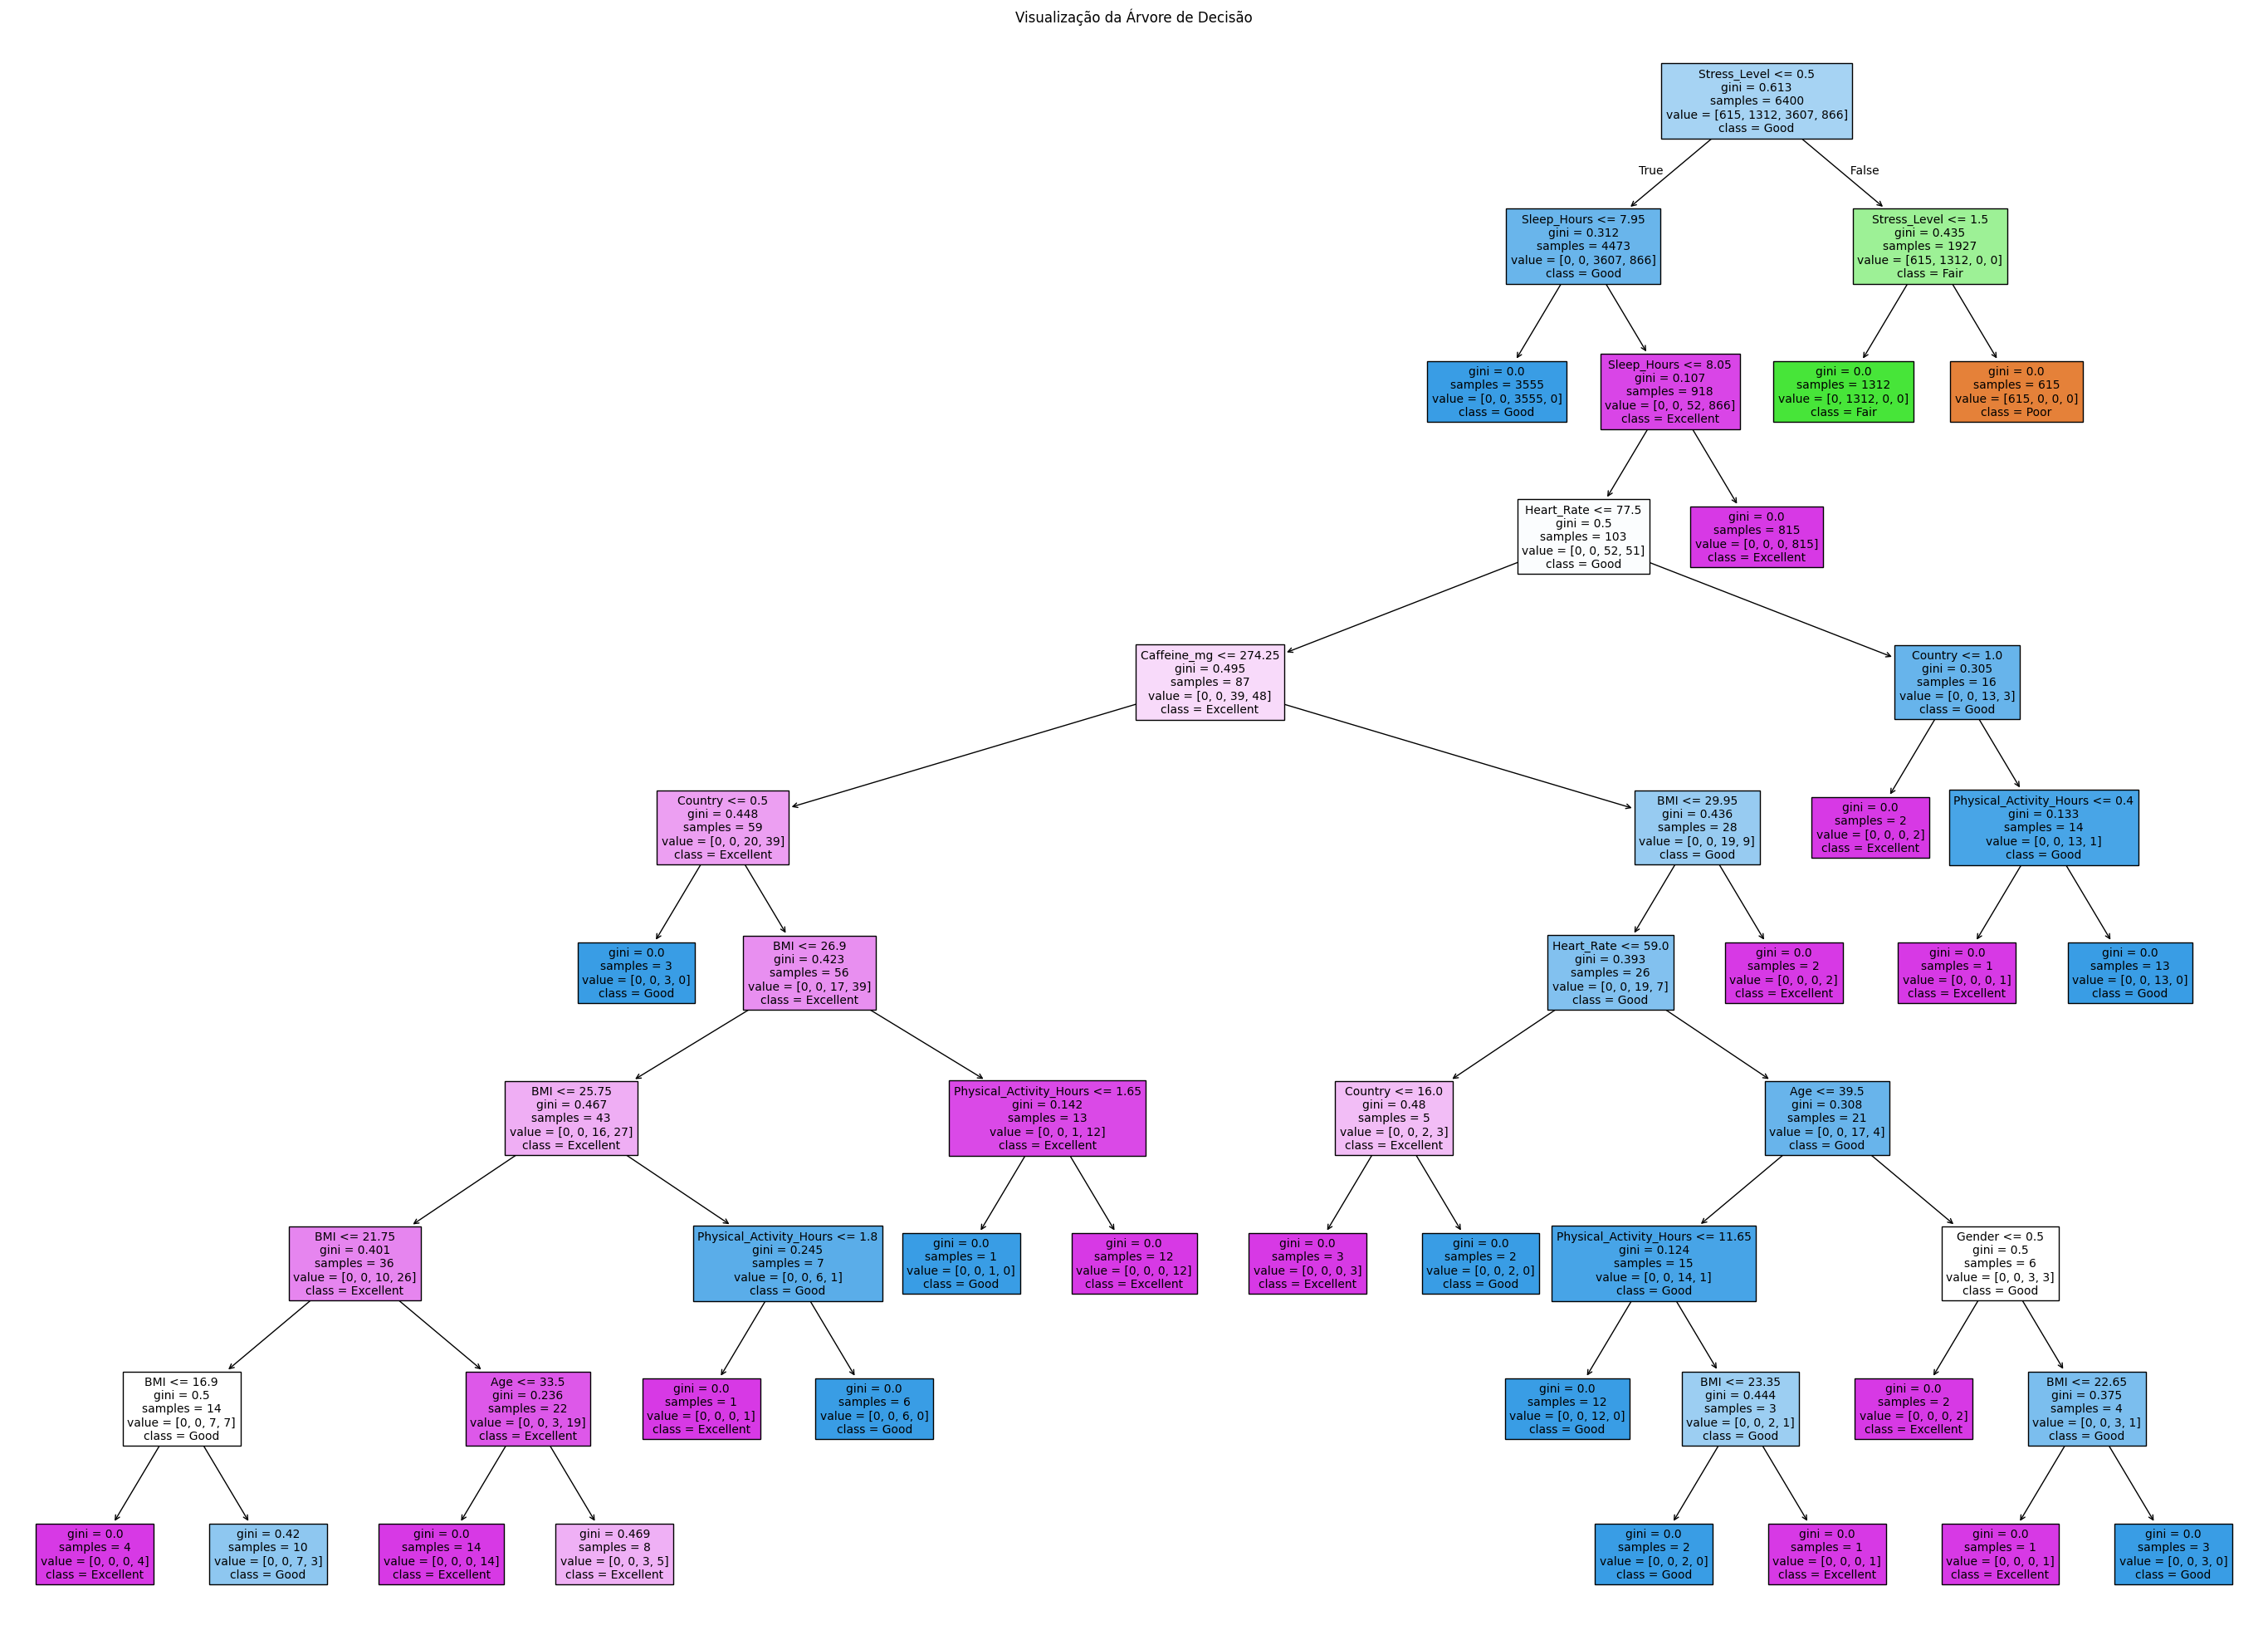

In [103]:
# Nomes das classes para a legenda do gráfico
# O mapeamento foi: {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
class_names_list = ['Poor', 'Fair', 'Good', 'Excellent']

plt.figure(figsize=(35, 25))
plot_tree(ad_model,
          feature_names=X_train.columns,
          class_names=class_names_list,
          filled=True,
          max_depth=None, # Limita a profundidade da visualização
          fontsize=10)
plt.title("Visualização da Árvore de Decisão")
plt.show()

## Interpretação

Shape dos valores SHAP: (1000, 13, 4)
Número de classes: 1000


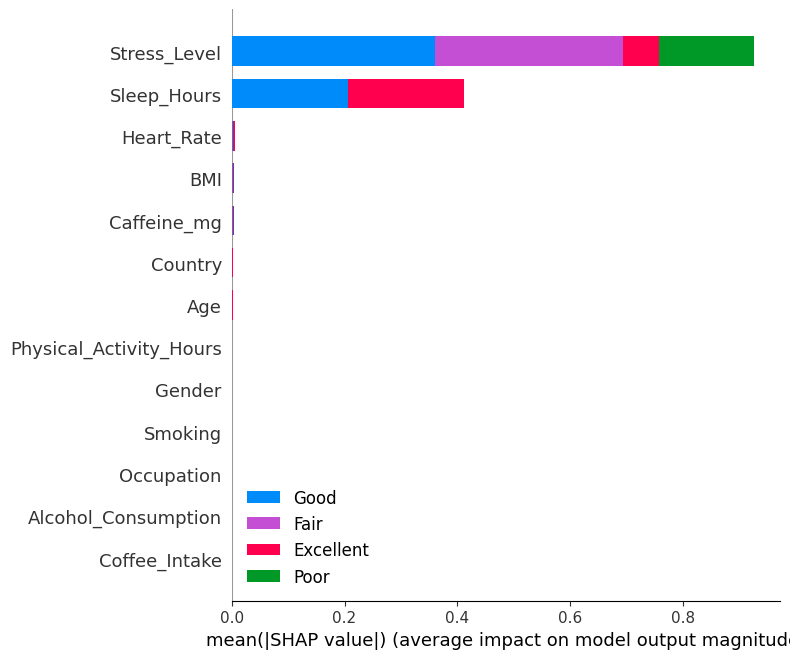

In [104]:
# Inicializa o explainer para árvores de decisão
explainer = shap.TreeExplainer(ad_model)

# Calcula os valores SHAP para o conjunto de teste (ou uma amostra dele)
sample_size = min(1000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)

shap_values = explainer.shap_values(X_test_sample)

# Se for classificação multiclasse, shap_values será uma lista
print(f"Shape dos valores SHAP: {np.array(shap_values).shape}")
print(f"Número de classes: {len(shap_values)}")

# Feature importance plot - importância geral das features
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", class_names=['Poor', 'Fair', 'Good', 'Excellent'])